In [1]:
import pandas as pd

In [2]:
events = pd.read_csv('./events.csv', encoding='utf-8')

In [3]:
events.head()

,Date,Customer,Holiday
0,18/04/2019,Cabinet Representative Visit,NaN
1,19/04/2019,NaN,1.0
2,22/04/2019,NaN,1.0
3,02/05/2019,NaN,NaN
4,06/05/2019,NaN,1.0


In [4]:
events.Date = pd.to_datetime(events.Date, format='%d/%m/%Y')

In [5]:
events.head()

,Date,Customer,Holiday
0,2019-04-18,Cabinet Representative Visit,NaN
1,2019-04-19,NaN,1.0
2,2019-04-22,NaN,1.0
3,2019-05-02,NaN,NaN
4,2019-05-06,NaN,1.0


In [6]:
events.Date.max()

Timestamp('2022-02-28 00:00:00')

In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1108 non-null   datetime64[ns]
 1   Customer  304 non-null    object        
 2   Holiday   24 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.1+ KB


In [8]:
events.set_index('Date', inplace=True)

In [9]:
events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1108 entries, 2019-04-18 to 2022-02-28
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Customer  304 non-null    object 
 1   Holiday   24 non-null     float64
dtypes: float64(1), object(1)
memory usage: 26.0+ KB


# Seasonality

In [10]:
events_filter = events.resample('W').count()

In [11]:
events_filter.head()

,Customer,Holiday
Date,,
2019-04-21,1,1
2019-04-28,0,1
2019-05-05,0,0
2019-05-12,0,1
2019-05-19,1,0


<AxesSubplot:xlabel='Date'>

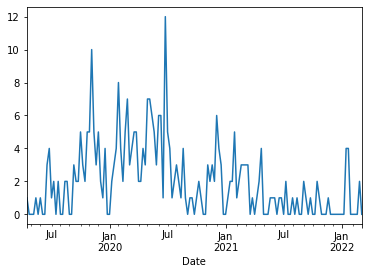

In [12]:
events_filter.Customer.plot()

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
decomp = seasonal_decompose(events_filter.Customer)

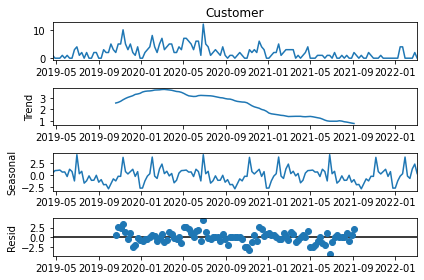

In [15]:
decomp.plot();

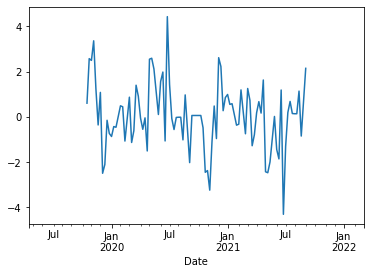

In [16]:
decomp.resid.plot();

# Autocorrelation

In [17]:
events_filter.shift()

,Customer,Holiday
Date,,
2019-04-21,NaN,NaN
2019-04-28,1.0,1.0
2019-05-05,0.0,1.0
2019-05-12,0.0,0.0
2019-05-19,0.0,1.0
...,...,...
2022-02-06,0.0,0.0
2022-02-13,0.0,0.0
2022-02-20,0.0,0.0


In [18]:
events_filter

,Customer,Holiday
Date,,
2019-04-21,1,1
2019-04-28,0,1
2019-05-05,0,0
2019-05-12,0,1
2019-05-19,1,0
...,...,...
2022-02-06,0,0
2022-02-13,0,0
2022-02-20,0,0


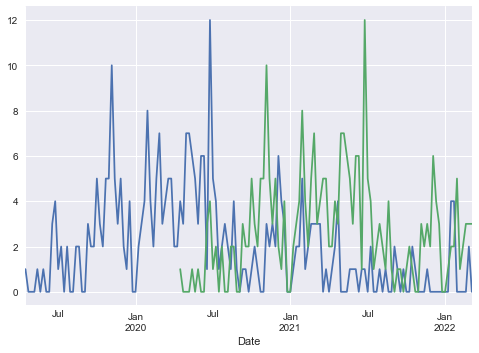

In [68]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, ax = plt.subplots()

events_filter.Customer.plot(ax=ax)
events_filter.Customer.shift(52).plot(ax=ax);

In [20]:
from scipy.stats import pearsonr

In [21]:
pearsonr(events_filter.Customer.iloc[52:], events_filter.shift(52).Customer.iloc[52:])

(-0.10567509287422731, 0.2978670060305927)

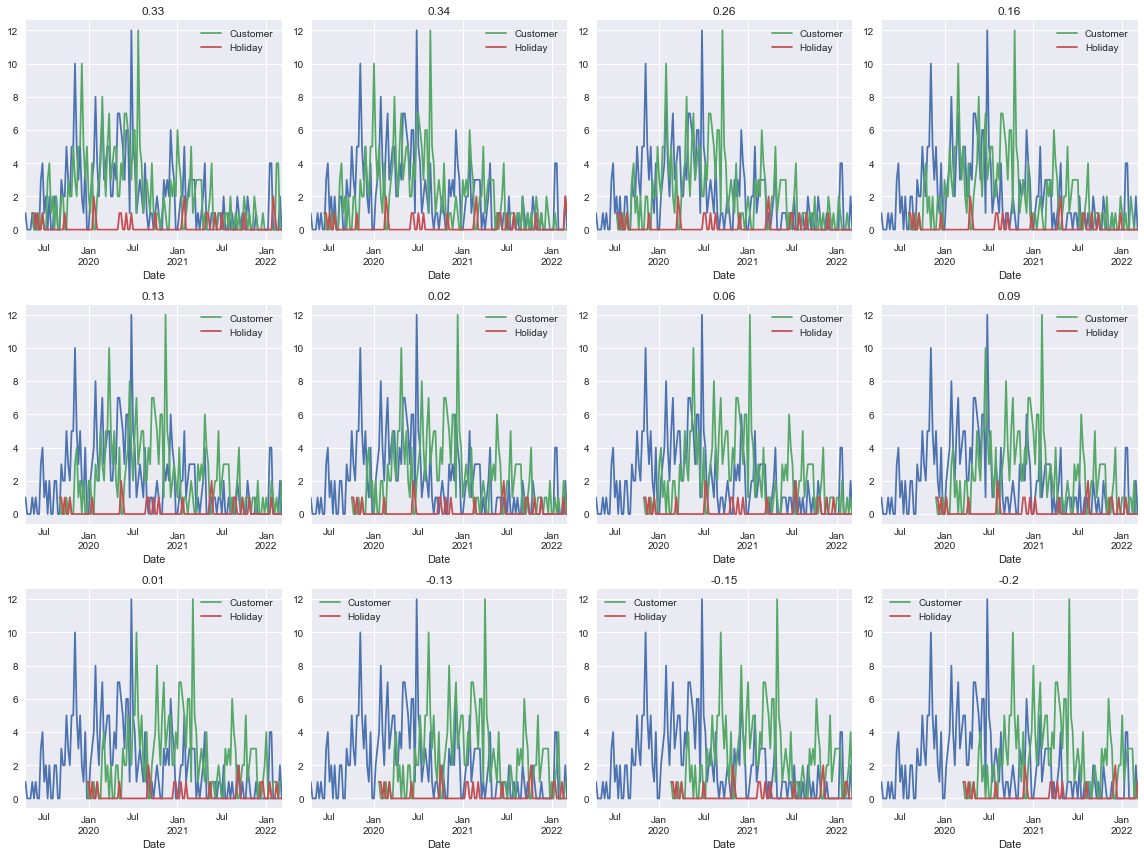

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

shift = 4

for row in range(3):
    for col in range(4):
        events_filter.Customer.plot(ax=ax[row][col])
        shifted = events_filter.shift(shift)
        shifted.plot(ax=ax[row][col])
        corr, _ = pearsonr(events_filter.Customer.iloc[shift:], shifted.Customer.iloc[shift:])
        corr = round(corr, 2)
        ax[row][col].set_title(corr)
        shift += 4
fig.tight_layout()

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

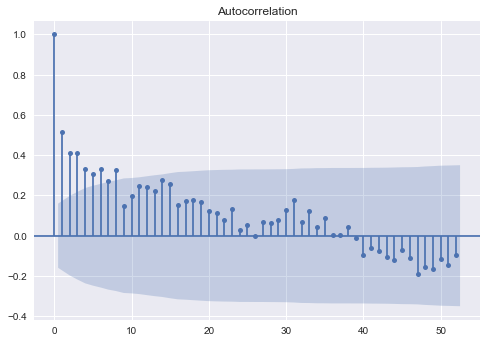

In [24]:
plot_acf(events_filter.Customer, lags=52);

# Linear Regression

In [25]:
from scipy import stats
from sklearn.linear_model import LinearRegression

In [26]:
model = LinearRegression()

In [27]:
features = events_filter[['Holiday']]
target = events_filter['Customer']

In [28]:
features

,Holiday
Date,
2019-04-21,1
2019-04-28,1
2019-05-05,0
2019-05-12,1
2019-05-19,0
...,...
2022-02-06,0
2022-02-13,0
2022-02-20,0


In [29]:
target

Date
2019-04-21    1
2019-04-28    0
2019-05-05    0
2019-05-12    0
2019-05-19    1
             ..
2022-02-06    0
2022-02-13    0
2022-02-20    0
2022-02-27    2
2022-03-06    0
Freq: W-SUN, Name: Customer, Length: 151, dtype: int64

In [30]:
model.fit(features, target)

LinearRegression()

In [31]:
model.intercept_, model.coef_

(2.1729893778452203, array([-1.00505817]))

So the regression line sklearn has fit to our data has an intercept of 2.17 and a slope of -1.005. So its equation is
$$\mathrm{Customer Event} = -1.005\times\mathrm{Holiday} - 2.17$$

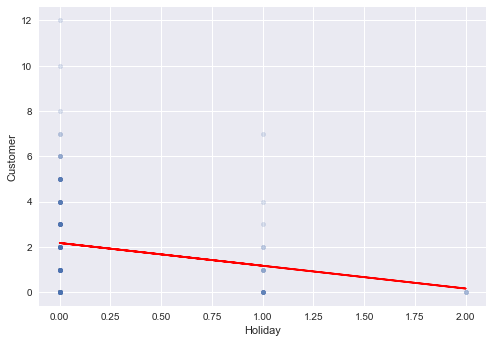

In [32]:
fig, axes = plt.subplots()

events_filter.plot(kind='scatter', x='Holiday', y='Customer', alpha=0.2, ax=axes)
axes.plot(events_filter['Holiday'], model.predict(events_filter[['Holiday']]), color='red');

In [33]:
model.predict([[1]])

array([1.16793121])

In [34]:
model.score(features, target)

0.036435215224852935

An r-squared score of 1 means the model is perfect (every prediction it's been tested on is exactly correct). An r-squared score of 0 means the model is performing exactly as well as the baseline model (the mean). A negative r-squared score means your model is worse than the baseline! So r-squared close to 1 is good, close to 0 is bad, negative is terrible. Values above 1 are not possible.

Mean squared error looks at the error of each prediction (the difference between the predicted value and the true value), squares it (to make it positive and so larger errors are penalised more harshly) and then averages this over all points. MSE is non-negative and the closer to 0 the better!

Root mean squared error (RMSE) is just the square root of the MSE. It carries the same information, but on the same scale as the data. It is essentially (thought not quite literally) the average amount your predictions are wrong by.

So the r-squared score is 3% - so our points are 3% less spread out around the red line than they are around the cyan line. The model explains 3% of the variation in the dataset - the remaining 97% is down to other factors (e.g., time of day) and random variation.

In [35]:
from sklearn.metrics import mean_squared_error as mse

In [36]:
mse(model.predict(features), target)

4.632599396369508

In [37]:
# rmse
mse(model.predict(features), target) ** 0.5

2.1523474153513202

So our model's predictions are typically wrong by about 2 events on average.

RMSE has a more direct interpretation in terms of the size of errors (it is roughly the average error), whereas r-squared score is more comparable across different contexts. It is impossible to say what value is good for RMSE without knowing about the context, whereas for r-squared score, good is close to 1, bad is close to 0, and it's much less context-sensitive.

In [38]:
pearsonr(events_filter.Customer, events_filter.Holiday)

(-0.19088010693849988, 0.01888915458203546)

# ARIMA Forecasting

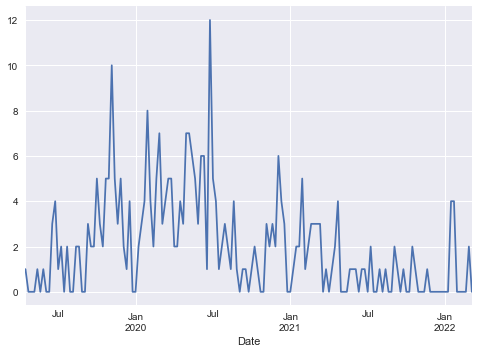

In [39]:
events_filter.Customer.plot();

In [40]:
events_filter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2019-04-21 to 2022-03-06
Freq: W-SUN
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Customer  151 non-null    int64
 1   Holiday   151 non-null    int64
dtypes: int64(2)
memory usage: 3.5 KB


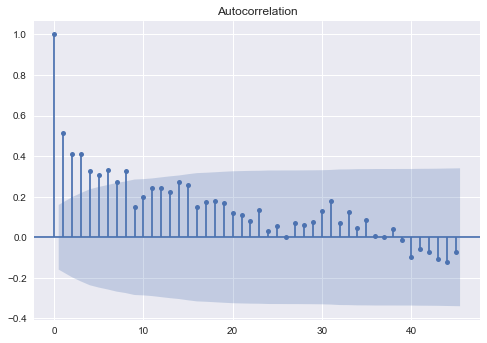

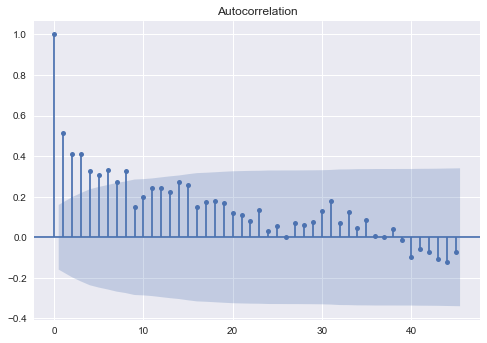

In [41]:
plot_acf(events_filter.Customer, lags = 45)

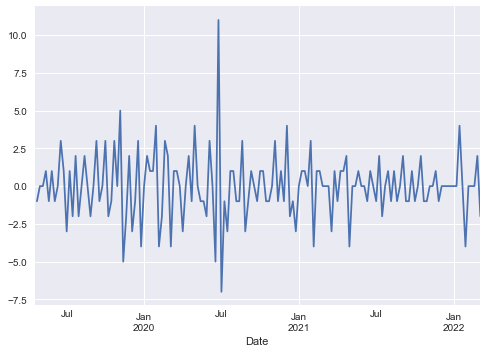

In [42]:
events_filter.Customer.diff().plot();

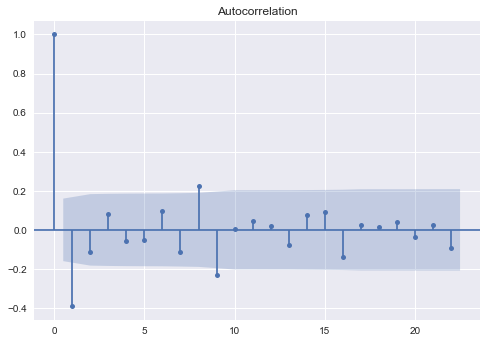

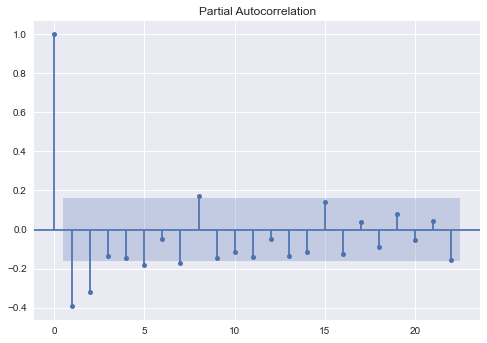

In [43]:
plot_acf(events_filter.Customer.diff().dropna());
plot_pacf(events_filter.Customer.diff().dropna());

in the ACF plot only 3 outside the blue confidence interval in the autocorrelation which is fine, we can legitimately ignore 1 in 20 points outside the 95% confirdence interval. The first is at week 1 and then one each at 8 and 9 weeks but they are only just outside but i have no reason to expect an 8 or 9 week seasonality in my series. This differenced model is now stationary and so an ARMA model can be applied. Times the data was differenced is 1 (so here $d=1$) which will be used to fit the ARIMA model.

in the PACF plot there are 2 values outside of the confidence interval before the lags are inside the confiedence interval so in this case $p = 2$

in the ACF plot there is only 1 plot before the lags go inside the confidence interval so in this case $q = 1$

so our parameters are $p=2, d=1, q=1$ making this an ARIMA (2, 1, 1) model

In [44]:
events_filter.Customer.shape

(151,)

In [45]:
train = events_filter.iloc[:139]
test = events_filter.iloc[139:]

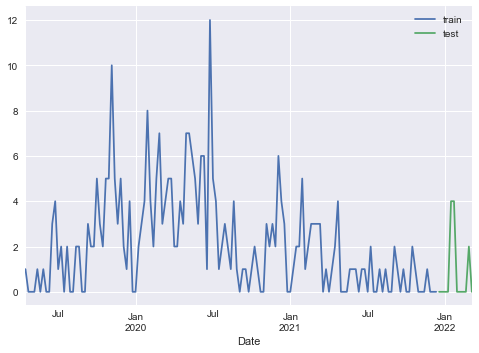

In [46]:
fig, ax = plt.subplots()

train.Customer.plot(ax=ax, label='train')
test.Customer.plot(ax=ax, label='test')
ax.legend(loc='best');

# SARIMA Model

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('seaborn')

In [48]:
train.Customer

Date
2019-04-21    1
2019-04-28    0
2019-05-05    0
2019-05-12    0
2019-05-19    1
             ..
2021-11-14    0
2021-11-21    1
2021-11-28    0
2021-12-05    0
2021-12-12    0
Freq: W-SUN, Name: Customer, Length: 139, dtype: int64

In [49]:
# model based on train dataset
model = SARIMAX(train.Customer, order=(2, 1, 1)).fit()

In [50]:
trended_model = SARIMAX(train.Customer, order=(2, 1, 1), trend='t').fit(method='powell', maxiter=500)

Optimization terminated successfully.
         Current function value: 2.006742
         Iterations: 5
         Function evaluations: 301


In [51]:
forecast = model.get_forecast(test.shape[0]).summary_frame()
trended_forecast = trended_model.get_forecast(test.shape[0]).summary_frame()

In [52]:
forecast

Customer,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-12-19,0.237969,1.824928,-3.338823,3.814762
2021-12-26,0.285784,1.935876,-3.508463,4.080031
2022-01-02,0.304559,1.994346,-3.604286,4.213405
2022-01-09,0.310174,2.034158,-3.676703,4.297051
2022-01-16,0.312026,2.069020,-3.743179,4.367230
2022-01-23,0.312614,2.101965,-3.807163,4.432390
2022-01-30,0.312803,2.133993,-3.869745,4.495352
2022-02-06,0.312864,2.165416,-3.931274,4.557002
2022-02-13,0.312884,2.196349,-3.991882,4.617650
2022-02-20,0.312890,2.226840,-4.051636,4.677416


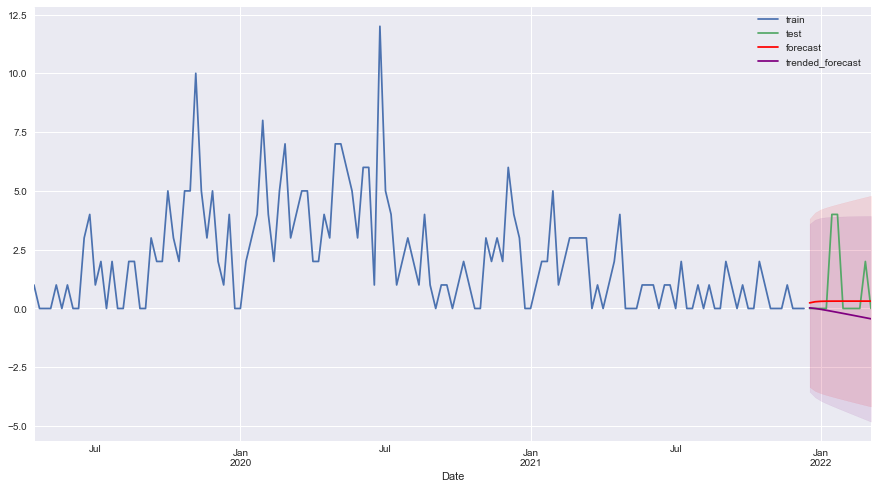

In [53]:
fig, ax = plt.subplots(figsize=(15,8))

# plot the original data
train.Customer.plot(ax=ax, label='train')
test.Customer.plot(ax=ax, label='test')

# plot the forecasts
forecast['mean'].plot(ax=ax, label='forecast', color='red')
trended_forecast['mean'].plot(ax=ax, label='trended_forecast', color='purple')

# shade in the confidence intervals
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='red', alpha=0.1)
ax.fill_between(trended_forecast.index, trended_forecast['mean_ci_lower'], trended_forecast['mean_ci_upper'], color='purple', alpha=0.1)

ax.legend(loc='best');

In [54]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(forecast['mean'], test.Customer))
print(mean_squared_error(trended_forecast['mean'], test.Customer))

2.5717499336868466
3.3811830940522696


suggests normal forecast is better model than the trended forecast because it has a lower mean squared error

In [55]:
# model based on the entire dataset
final_model = SARIMAX(events_filter.Customer, order=(2,1,1)).fit(method='powell')

Optimization terminated successfully.
         Current function value: 2.000353
         Iterations: 5
         Function evaluations: 255


In [56]:
final_forecast = final_model.get_forecast(12).summary_frame()

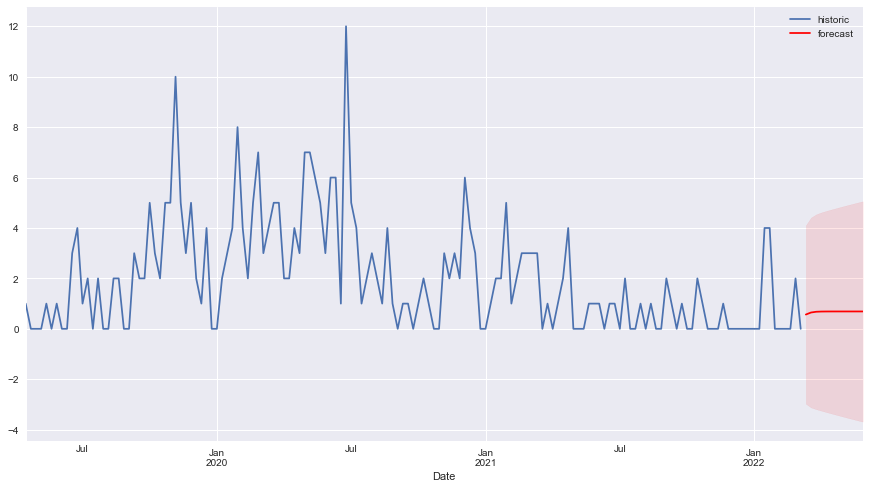

In [57]:
fig, ax = plt.subplots(figsize=(15,8))

# plot the original data
events_filter.Customer.plot(ax=ax, label='historic')

# plot the forecasts
final_forecast['mean'].plot(ax=ax, label='forecast', color='red')

# shade in the confidence intervals
ax.fill_between(final_forecast.index, final_forecast['mean_ci_lower'], final_forecast['mean_ci_upper'], color='red', alpha=0.1)

ax.legend(loc='best');

This forecast is typical to what was expected, it has a wide confidence interval which means the model is not confident in its predictions. Based on the previous data, we can see many points with sharp, big changes in the values. This makes the dataset dificult to forecast.

# SARIMAX Model

In [58]:
exog_train = events_filter['Holiday'].iloc[:139]
exog_test = events_filter['Holiday'].iloc[139:]

In [59]:
holiday_model = SARIMAX(train.Customer, order=(2,1,1), exog=exog_train).fit(method='powell')

Optimization terminated successfully.
         Current function value: 1.982684
         Iterations: 6
         Function evaluations: 351


In [60]:
events_filter.index[-1]

Timestamp('2022-03-06 00:00:00', freq='W-SUN')

In [61]:
forecast_period = pd.date_range(start="2022-03-06", periods=12, freq="W-SUN")

In [62]:
exog_forecast = forecast_period.map(events_filter.Holiday).values

In [63]:
exog_forecast

array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [64]:
holiday_forecast = holiday_model.get_forecast(12, exog=exog_test).summary_frame(alpha=0.1)

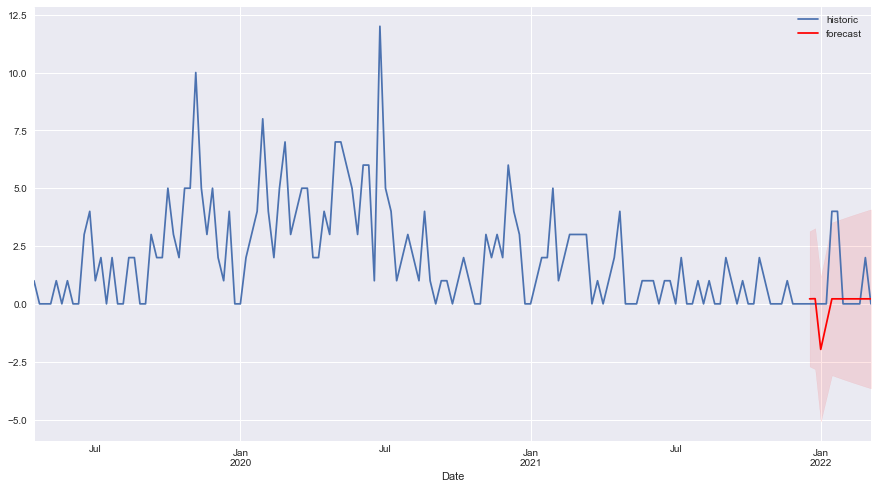

In [65]:
fig, ax = plt.subplots(figsize=(15,8))

# plot the original data
events_filter.Customer.plot(ax=ax, label='historic')

# plot the forecasts
holiday_forecast['mean'].plot(ax=ax, label='forecast', color='red')

# shade in the confidence intervals
ax.fill_between(holiday_forecast.index, holiday_forecast['mean_ci_lower'], holiday_forecast['mean_ci_upper'], color='red', alpha=0.1)

ax.legend(loc='best');

In [66]:
print(mean_squared_error(holiday_forecast['mean'], test.Customer))

3.0653564039160206
